In [1]:
import pandas as pd 
import numpy as np

# Input data
data = pd.read_csv('../input/train_labels.csv')
sub = pd.read_csv('../input/sample_submission.csv')
path = '../input'

In [2]:
# Import fastai libraries
from fastai import *
from fastai.vision import *
from torchvision.models import * 

In [3]:
# Data augmentation
transforms = get_transforms(do_flip = True, flip_vert = True, max_rotate =5.0, max_zoom =1.1,
                            max_lighting = 0.1, max_warp = 0.1)

In [4]:
# Specify training and test data set
sz=96
data = ImageDataBunch.from_csv(path, folder='train', csv_labels = 'train_labels.csv', 
                               ds_tfms = transforms, size =sz, suffix ='.tif', test ='test', bs =128)
stats =data.batch_stats()
data.normalize(stats)

ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
1,0,0,0,1
Path: ../input;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: ../input;

Test: LabelList (57458 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: ../input

In [5]:
from sklearn.metrics import roc_auc_score

# Define roc-auc metric
def auc_score(y_pred, y_true, tensr = True):
    score = roc_auc_score(y_true, y_pred[:,1])
    if tensr:
        score = tensor(score)
    return score

# Training

In [6]:
# Specify tansfer learning model
arch = densenet169 
learner = cnn_learner(data, arch, pretrained = True, path='.',
                     metrics = [accuracy, auc_score],ps=0.5)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /tmp/.torch/models/densenet169-b2777c0a.pth
57365526it [00:01, 37144175.65it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


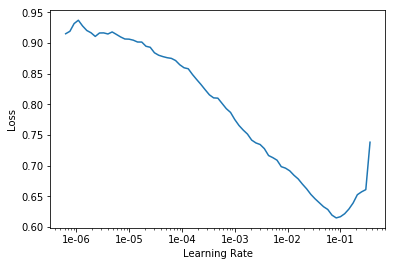

In [7]:
# Find a proper learning rate for training
learner.lr_find()
learner.recorder.plot()

In [8]:
# Training
learner.fit_one_cycle(8, 2e-2)
learner.recorder.plot_lr()
learner.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.215667,0.199754,0.924440,0.973137,10:55


In [9]:
# Save the model
learner.save('Densenet169_stage1')

In [10]:
# Predict tumor probability for the validation set
preds, y = learner.TTA(with_loss=False)

In [11]:
# Get validation accuracy
acc = accuracy(preds, y)
print('The validation accuracy is {0} %.'.format(acc))

The validation accuracy is 0.9593001008033752 %.


In [12]:
from sklearn.metrics import roc_curve, auc

# Get validation AUC-ROC score
# predicted tumor probability
probs = preds[:,1]

# Compute false positive rate and  true positive rate
fpr, tpr, _ = roc_curve(y, probs)

# Compute ROC-AUC score
roc_auc = auc(fpr, tpr)
print('The ROC-AUC score for the validation set is {}'.format(roc_auc))

The ROC-AUC score for the validation set is 0.9903895623681795


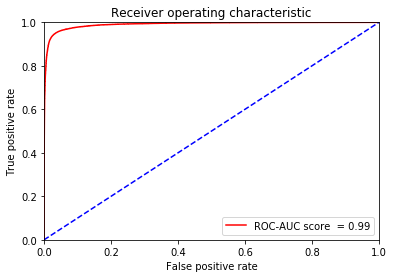

In [13]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC-AUC score  = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve_Stage1.jpg')

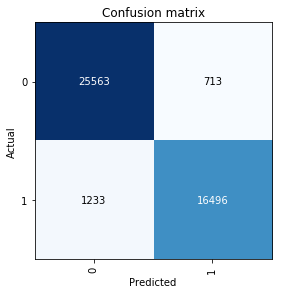

In [14]:
interp = ClassificationInterpretation.from_learner(learner)
# Confusion matrix
interp.plot_confusion_matrix(title='Confusion matrix')

In [15]:
# Predict tumor probabilties for test data sets
preds_test,_=learner.TTA(ds_type=DatasetType.Test)

In [16]:
# Create a submission file 
sub_list = list(sub.id)

pred_list = list(preds_test[:,1])
pred_dict = dict((key, value.item()) for (key, value) 
                 in zip(learner.data.test_ds.items,pred_list))
# Create a new list with the same order as in sample_submission
pred_ordered = [pred_dict[Path('../input/test/' + id + '.tif')] for id in sub_list]
submissions = pd.DataFrame({'id':sub_list,'label':pred_ordered})
submissions.to_csv('sample_submission_densenet169_stage1.csv',
                   header=True, index = False)

# Finetuning

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


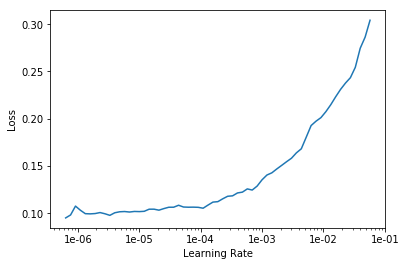

In [17]:
# unfreeze and run learning rate finder again
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [18]:
# finetuning
learner.fit_one_cycle(8,slice(2e-5,1e-4))
learner.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,auc_score,time
0,0.117915,0.120762,0.956096,0.989898,10:56
1,0.127296,0.121941,0.956028,0.989551,09:35


In [19]:
# Save the model
learner.save('Densenet169_stage2')

In [20]:
# Predict tumor probability for the validation set
preds, y = learner.TTA(with_loss=False)

In [21]:
# Get validation accuracy
acc = accuracy(preds, y)
print('The validation accuracy is {0} %.'.format(acc))

The validation accuracy is 0.9663901925086975 %.


In [22]:
# Get validation AUC-ROC score
# predicted tumor probability
probs = preds[:,1]

# Compute false positive rate and  true positive rate
fpr, tpr, _ = roc_curve(y, probs)

# Compute ROC-AUC score
roc_auc = auc(fpr, tpr)
print('The ROC-AUC score for the validation set is {}'.format(roc_auc))

The ROC-AUC score for the validation set is 0.9930108929021283


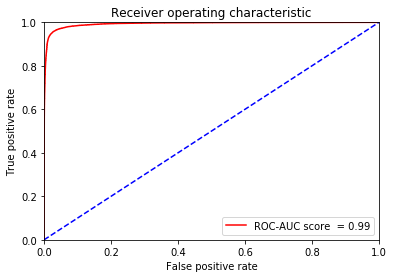

In [23]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC-AUC score  = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve_Stage2.jpg')

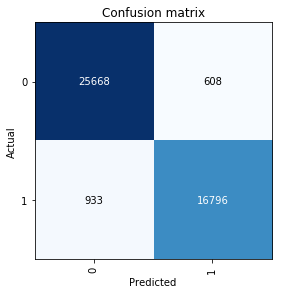

In [24]:
interp = ClassificationInterpretation.from_learner(learner)
# Confusion matrix
interp.plot_confusion_matrix(title='Confusion matrix')

In [25]:
# Predict tumor probabilties for test data sets
preds_test,_=learner.TTA(ds_type=DatasetType.Test)

In [26]:
# Create a submission file 

sub_list = list(sub.id)
pred_list = list(preds_test[:,1])
pred_dict = dict((key, value.item()) for (key, value) 
                 in zip(learner.data.test_ds.items,pred_list))
# Create a new list with the same order as in sample_submission
pred_ordered = [pred_dict[Path('../input/test/' + id + '.tif')] for id in sub_list]
submissions = pd.DataFrame({'id':sub_list,'label':pred_ordered})
submissions.to_csv('sample_submission_densenet169_stage2.csv',
                   header=True, index = False)

# Free-Form Visualization

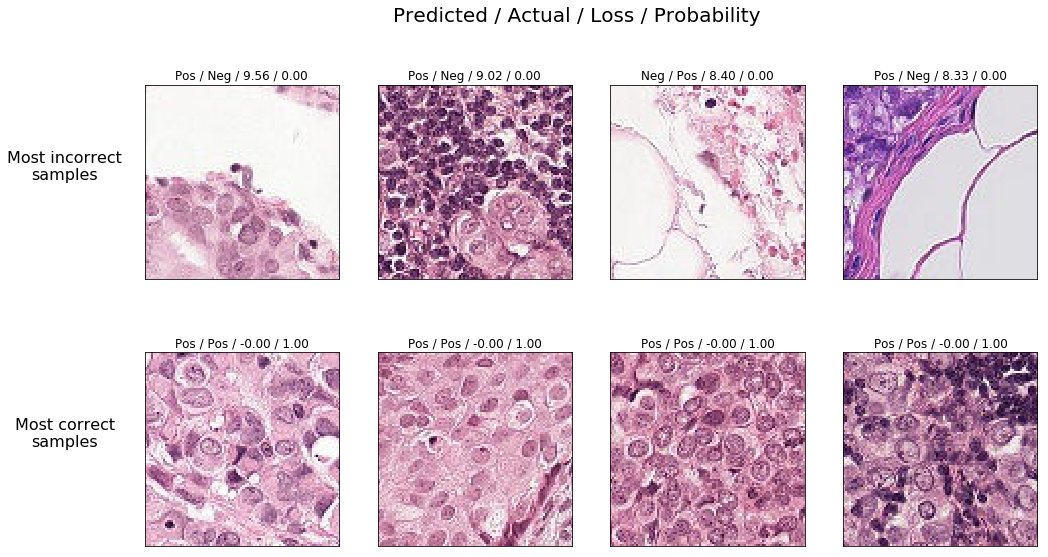

In [27]:
# Visualize the most correct and incorrect predictions

# top losses will return all validation losses and indexes sorted by the largest first
val_loss,val_idx = interp.top_losses()

classes=['Neg','Pos']

fig, ax = plt.subplots(2,4, figsize=(16,9))
fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
for i in range(4):
    idx = val_idx[i]
    imag,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
    cl = int(cl)
    imag = image2np(imag.data)
    ax[0,i].imshow(imag)
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
ax[0,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)    

for i in range(4):
    idx = val_idx[len(val_idx) - i - 1]
    imag,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
    cl = int(cl)
    imag = image2np(imag.data)
    ax[1,i].imshow(imag)
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
ax[1,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)
plt.savefig('Most_Incorrect_and_Correct_Predictions.jpg')